# Prediction Task
Binary classification to predict whether the machine fails or not.
Target or output variable for this classification is the 'Machine Status' where '1' represents machine failure and '0' represents normal.

# Background Research

World's largest manufacturers lose about $1 Trillion anually to machine failures. 

By building a predictive model, it allows these manufacturers to be able to plan their maintenance to minimize loss and also to find out what are the most contributing factors to machine failure. In our case, we have factors such as temperature, rotation speed, torque force, tool wear and the quality of our machine.

This process is known as predictive maintenance where the ultimate goal is to find patterns that can help predict and even prevent machine failures and this brings about two main benefits.
<ol>
    <li>Reducing loss due to machine failure</li>
    <li>Maximizing operational efficiency due to less downtime</li>
</ol>

References:

https://www.automation.com/en-us/articles/june-2021/world-largest-manufacturers-lose-almost-1-trillion 

https://analyticsindiamag.com/how-to-predict-machine-failure-using-data-science/ 

https://towardsdatascience.com/how-to-implement-machine-learning-for-predictive-maintenance-4633cdbe4860 

# Import modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Import sklearn modules

In [2]:
# Pre-processing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Evaluation
from sklearn.metrics import recall_score, classification_report, precision_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, StratifiedKFold

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, validation_curve

# Model intepretability
from sklearn.inspection import permutation_importance

In [3]:
# Loading the dataset
factoryDataset = pd.read_csv('factory_data (classification).csv')

# Exploratory Data Analysis

In [4]:
# Copy original dataset for EDA
factoryEDA = factoryDataset.copy()

In [5]:
# See the first 5 rows of the dataset
factoryEDA.head()

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0


In [6]:
# See the last 5 rows of the dataset
factoryEDA.tail()

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
19995,19996,T87335,M,25.75,35.35,NaN,29.5,14,0
19996,19997,Z59525,H,25.85,35.35,1632.0,31.8,17,0
19997,19998,T83921,M,25.95,NaN,NaN,33.4,22,0
19998,19999,K42424,H,25.95,35.65,1408.0,48.5,25,0
19999,20000,Z10048,M,25.95,35.65,1500.0,40.2,30,0


From a first glance, it can be seen that unique and product id are probably used for identifying the machine, so it probably would not be useful for our classification. Also, we notice that this dataset contains null values, so we have to deal with that later and there also a mix of categorical and numerical features.

In [7]:
# See datatype of each column
factoryEDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unique ID             20000 non-null  int64  
 1   Product ID            20000 non-null  object 
 2   Quality               19009 non-null  object 
 3   Ambient T (C)         20000 non-null  float64
 4   Process T (C)         19600 non-null  float64
 5   Rotation Speed (rpm)  18812 non-null  float64
 6   Torque (Nm)           20000 non-null  float64
 7   Tool Wear (min)       20000 non-null  int64  
 8   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.4+ MB


In [8]:
# See the numerical summary of numerical columns
factoryEDA.describe()

,Unique ID,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
count,20000.000000,20000.000000,19600.000000,18812.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,26.904930,36.904291,1538.795397,39.986910,107.951000,0.033900
std,5773.647028,2.000834,1.483647,178.674963,9.968684,63.652555,0.180976
min,1.000000,22.150000,32.550000,1168.000000,3.800000,0.000000,0.000000
25%,5000.750000,25.250000,35.750000,1423.000000,33.200000,53.000000,0.000000
50%,10000.500000,26.950000,36.950000,1503.000000,40.100000,108.000000,0.000000
75%,15000.250000,28.450000,37.950000,1613.000000,46.800000,162.000000,0.000000
max,20000.000000,31.450000,40.750000,2886.000000,76.600000,253.000000,1.000000


In [9]:
# See the  number of null values in each column
factoryEDA.isna().sum()

Unique ID                  0
Product ID                 0
Quality                  991
Ambient T (C)              0
Process T (C)            400
Rotation Speed (rpm)    1188
Torque (Nm)                0
Tool Wear (min)            0
Machine Status             0
dtype: int64

Using the pandas `.info()` function, we can see that the dataset has 20000 rows and 9 columns. There are both categorical and numerical columns in the dataset.

The pandas `.describe()` function allows us to see the descriptive summary of the numerical features of our dataset. It can be seen that for 'Rotation Speed (rpm)' and 'Torque (Nm)' have maximum values that are well above the 75th percentile which indicates that there could be outliers in those features.

Using `.isna().sum()` we can see that there are 991 null values under the 'Quality' feature, 400 null values under the 'Process T (C)' feature and 1188 null values under the 'Rotation Speed (rpm)' feature. Since there are so many null values, it would not be logical to drop all of them as it would result in huge data loss. Instead, we will be exploring other methods to handle the missing values such as using `IterativeImputer()` under the `sklearn.impute` library.

In [10]:
# See the number of unique values in each column
for i in factoryEDA:
    print(f"'{i}' column has {len(factoryEDA[i].unique())} unique values.")

'Unique ID' column has 20000 unique values.
'Product ID' column has 19408 unique values.
'Quality' column has 4 unique values.
'Ambient T (C)' column has 94 unique values.
'Process T (C)' column has 84 unique values.
'Rotation Speed (rpm)' column has 942 unique values.
'Torque (Nm)' column has 577 unique values.
'Tool Wear (min)' column has 246 unique values.
'Machine Status' column has 2 unique values.


It can be seen that for the categorical feature `Quality` there are only 3 unique values (exclude NaN).

For `Product ID` there are 19408 unique values. This means that there are machines of the same product type. However, these duplicates should not be dropped as although they have the same product id, the machines are of different qualities.

In [11]:
# Show that same product id machines have different qualities
ids = factoryEDA["Product ID"]
factoryEDA[ids.isin(ids[ids.duplicated()])].sort_values("Product ID")

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
9060,9061,K10260,H,24.05,35.15,1453.0,45.8,105,0
13122,13123,K10260,L,26.95,36.25,1473.0,46.0,35,0
18433,18434,K10284,M,25.75,37.05,1501.0,48.7,192,0
16637,16638,K10284,H,28.45,37.45,1453.0,48.0,124,0
962,963,K10573,M,22.65,33.45,1480.0,43.2,92,0
...,...,...,...,...,...,...,...,...,...
9372,9373,Z85369,L,24.55,35.25,1487.0,41.4,84,0
1052,1053,Z87344,L,23.55,34.55,1927.0,23.9,112,0
13739,13740,Z87344,M,29.15,38.15,1663.0,29.6,115,0
6383,6384,Z87748,H,27.05,36.55,1483.0,43.8,108,0


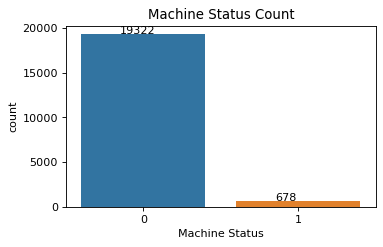

In [12]:
# Plot countplot to see number of machines of low medium and high qualities
plt.figure(figsize=(5,3), dpi=80)
ax = sns.countplot(x='Machine Status', data=factoryEDA, order = factoryEDA['Machine Status'].value_counts().index)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.title('Machine Status Count')
plt.show()

This count plot for number of machines who are labeled '0' or '1' under 'Machine Status' shows that this dataset is imbalanced where machine failure denoted by '1' has a significantly lower occurence than functional machines denoted by '0'.

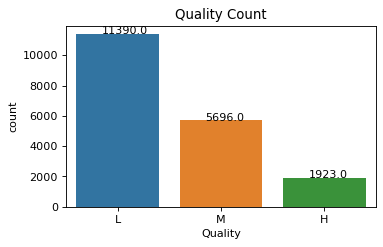

In [13]:
# Plot countplot to see number of machines of low medium and high qualities
plt.figure(figsize=(5,3), dpi=80)
ax = sns.countplot(x='Quality', data=factoryEDA, order = factoryEDA['Quality'].value_counts().index)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.title('Quality Count')
plt.show()

From the count plot we can see that there is significantly more low quality machines in our dataset than medium and high quality with 11390, 5696 and 1923 machines respectively.

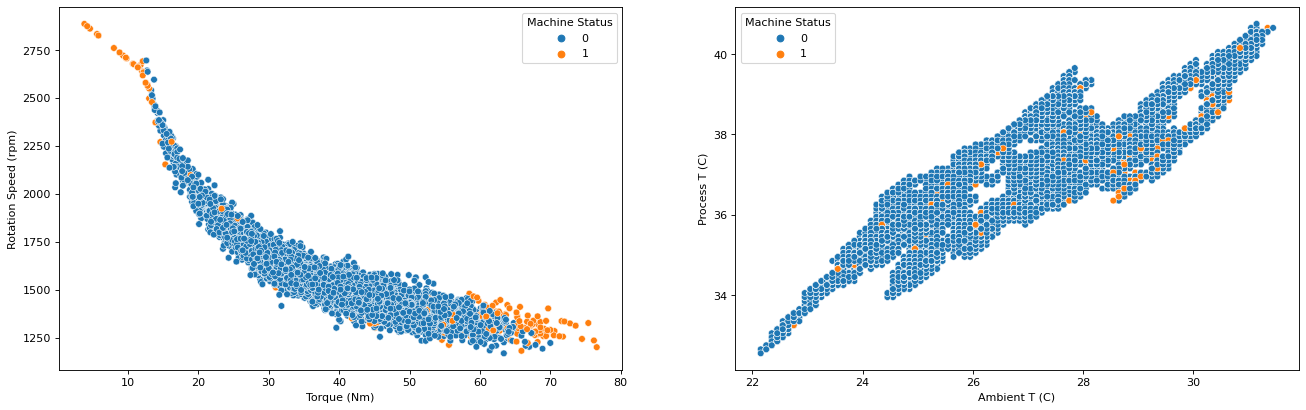

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=80)
# Scatterplot for Torque VS Rotation Speed
sns.scatterplot(x=factoryEDA['Torque (Nm)'], y=factoryEDA['Rotation Speed (rpm)'], hue=factoryEDA['Machine Status'], ax=ax[0])
# Scatterplot for Ambient T (C) VS Process T (C)
sns.scatterplot(x=factoryEDA['Ambient T (C)'], y=factoryEDA['Process T (C)'], hue=factoryEDA['Machine Status'], ax=ax[1])
plt.show()

There are two pairs of variables that are highly correlated in our dataset. First, "Ambient T (C)" and "Process T (C)". Second "Rotation Speed (rpm)" and "Torque (Nm)". 

This introduces multicollinearity which means that there would be redundant information. This will be deaalt with later during feature selection.

The outliers in the "Rotation Speed (rpm)" and "Torque (Nm)" are mostly machine failures and it will be left as it is as removing them would mean that there would be less data on machine failure which will lead to a greater imbalanced dataset.

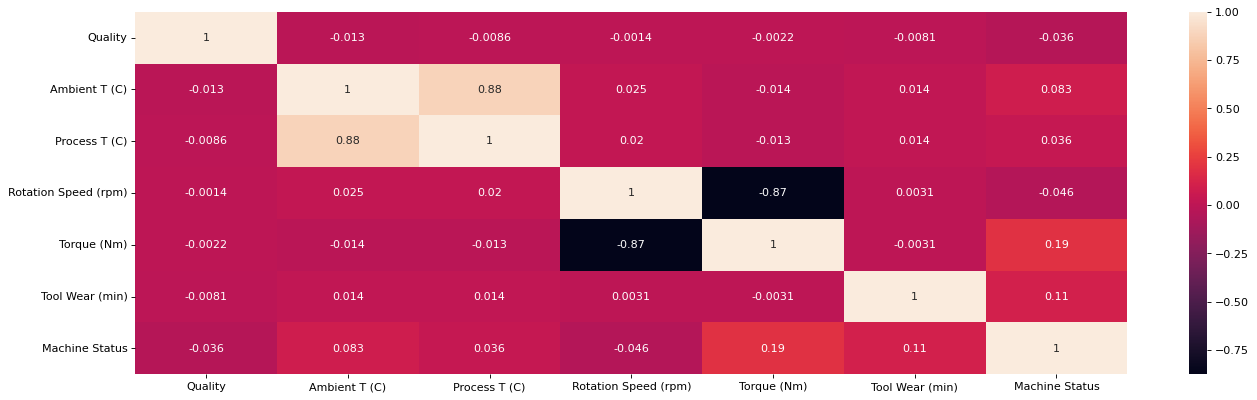

In [15]:
# Encode 'Quality' column using OrdinalEncoder
ordEnc = OrdinalEncoder(categories=[['L', 'M', 'H']], handle_unknown='use_encoded_value', unknown_value=np.NaN)
factoryEDA['Quality'] = ordEnc.fit_transform(factoryEDA[['Quality']])

# Plot heatmap to visualise correlations and identify strong correlations
correlation = factoryEDA.iloc[:,2:].corr()
plt.figure(figsize=(20, 6), dpi=80)
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.show()

As we can see from the heatmap, those two pairs of variables do indeed have a high correlation of 0.88 and -0.87 respectively.

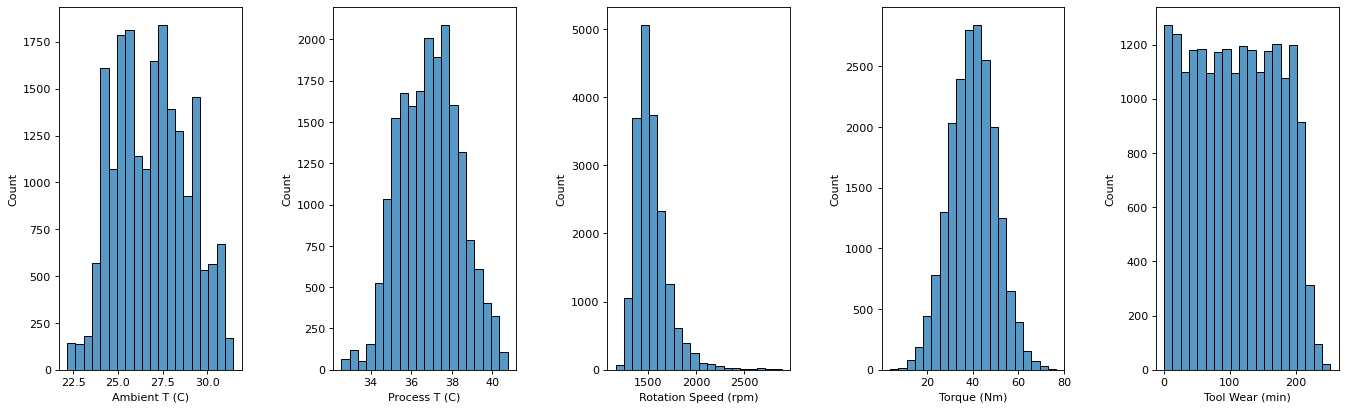

In [16]:
# Plot histplot to see the distribution of data in the numerical columns
fig, ax = plt.subplots(1, 5, figsize=(20, 6), dpi=80)
for i in range(3,8,1):
    sns.histplot(x=factoryEDA.iloc[:,i], data=factoryEDA, bins=20, ax=ax[i-3])

plt.subplots_adjust(left=0.1, right=0.9, wspace=0.5, hspace=0.2)
plt.show()

We can see from the histplots that "Ambient T (C)" and "Process T (C)" follows an almost normal distribution. For "Rotation Speed (rpm)" the data is skewed to the right because of outliers and that will be addressed later on why it should be kept. "Torque (Nm)" follows a normal distribution however, it also contains outliers. Lastly, for "Tool Wear (min)" it seems like there is an almost uniform distribution.

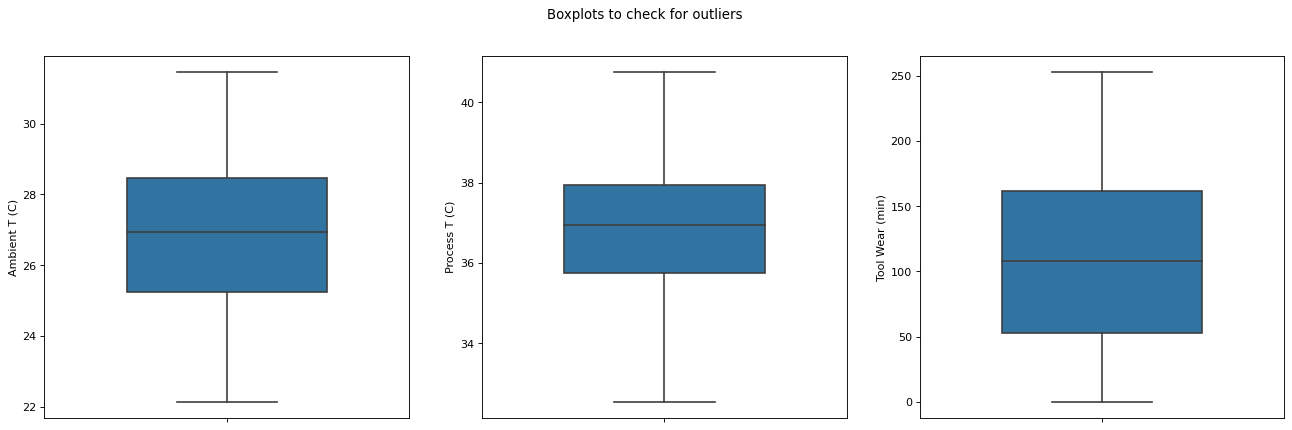

In [17]:
# Boxplot to check for outliers (These three columns do not show any distinct outliers)
fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=80)
sns.boxplot(y=factoryEDA['Ambient T (C)'], width=0.55, ax=ax[0])
sns.boxplot(y=factoryEDA['Process T (C)'], width=0.55, ax=ax[1])
sns.boxplot(y=factoryEDA['Tool Wear (min)'], width=0.55, ax=ax[2])

fig.suptitle('Boxplots to check for outliers')
plt.show()

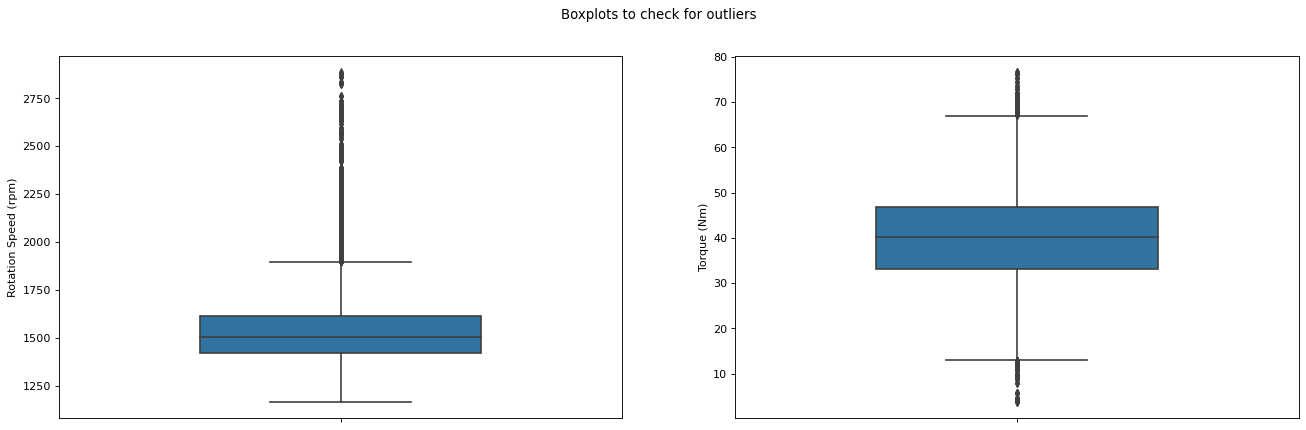

In [18]:
# Boxplot to check for outliers (These two columns have distinct outliers)
fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=80)
sns.boxplot(y=factoryEDA['Rotation Speed (rpm)'], width=0.5, ax=ax[0])
sns.boxplot(y=factoryEDA['Torque (Nm)'], width=0.5, ax=ax[1])

fig.suptitle('Boxplots to check for outliers')
plt.show()

From the boxplots, we can see that both "Rotation Speed (rpm)" and "Torque (Nm)" have distintct outliers. Deeper analysis on these outliers will be carried out by using Tukey's fences.

Upper fence states that any value that is above the value of the 3rd Quartile + 1.5 times of the interquartile range are considered outliers.

Lower fence states that any value that is lower than the value of the 1st Quartile - 1.5 times of the interquartile range are considered outliers.

(Interquartile range referes to the range bewteen the 1st and 3rd Quartile (25th percentile to 75th percentile) )

In [19]:
# Find the first and third quartile of 'Torque (Nm)'
q1, q3 = np.percentile(factoryEDA['Torque (Nm)'].astype("i"), [25,75])
# Find the inter quartile range of 'Torque (Nm)'
iqr = q3 -q1

# Find the outliers (larger values than the upper fence value)
upperOutliers = factoryEDA[factoryEDA['Torque (Nm)'] > (q3 + 1.5*iqr)]
# Count the number of machines that failed and are normal that are outliers
upperOutliers['Machine Status'].value_counts()

1    92
0    20
Name: Machine Status, dtype: int64

In [20]:
# Find the outliers (smaller values than the lower fence value)
lowerOutliers = factoryEDA[factoryEDA['Torque (Nm)'] < (q1 - 1.5*iqr)]
# Count the number of machines that failed and are normal that are outliers
lowerOutliers['Machine Status'].value_counts()

1    56
0    10
Name: Machine Status, dtype: int64

For "Torque (Nm)" there are a total of 112 machines who lie beyond the upper fence and of which, 92 machines are machines that have failed and 20 are machines that are still functional.

There are 66 machines that lie below the lower fence and 56 of them are machines that failed while the remaining 10 are machines that are still functioning.

Normally, we would remove these outliers but because we already have very less machines of failure class denoted by "1", we should not remove them as it would make the data even more imbalanced.

In [21]:
# Find the first and third quartile of 'Rotation Speed (rpm)'
nonull = factoryEDA[factoryEDA['Rotation Speed (rpm)'].notnull()]
q1, q3 = np.percentile(nonull['Rotation Speed (rpm)'], [25,75])
# Find the interquartile range of 'Rotation Speed (rpm)'
iqr = q3 - q1

# Find the outliers (larger values than the upper fence value)
rotationUpperOutliers = nonull[nonull['Rotation Speed (rpm)'] > (q3 + 1.5*iqr)]
# Count the number of machines that failed and are normal that are outliers
rotationUpperOutliers['Machine Status'].value_counts()

0    706
1     65
Name: Machine Status, dtype: int64

For "Rotation Speed (rpm)" there were only outliers at the top of the boxplot, hence only upper fence theorem will be used. There are 771 machines that lie above the upper fence and 706 of them are machines that are functioning and 65 of them are machines that failed. Similarly, there are too many machines that are outliers and if we remove them, there would be quite a lot of useful data lost. So, the outliers will be kept.

Setting a random state

In [22]:
# Creating random state used later
randoms = np.random.RandomState(228)

<b>Splitting the data</b>

Splitting the data into features and target variable (Machine Status).

Perform `train-test-split` for the data into train set and held-out test set for final model prediction with a ratio of <b>8:2</b>.

In [23]:
# Split the data into features and target
y = factoryDataset['Machine Status']
X = factoryDataset.drop('Machine Status', axis=1)

In [24]:
# Train test split to get training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=randoms)

# Preprocessing

`Unique ID` and `Product ID` will be dropped as they will not be useful to our model. 

Recognise that `Quality` feature has values that can be ranked (e.g. 'L' referring to low quality machines are worse than 'M' and 'H' referring to medium and high quality machines). Therefore we can also ordinal encode the `Quality` feature using sklearn `OrdinalEncoder()`.

In [25]:
# Drop Unique ID and Product ID as not useful for model training
X_train.drop(['Unique ID', 'Product ID'], axis=1, inplace=True)
X_test.drop(['Unique ID', 'Product ID'], axis=1, inplace=True)

In [26]:
# Encode 'Quality' column using OrdinalEncoder
ordEnc = OrdinalEncoder(categories=[['L', 'M', 'H']], handle_unknown='use_encoded_value', unknown_value=np.NaN)
X_train['Quality'] = ordEnc.fit_transform(X_train[['Quality']])
X_test['Quality'] = ordEnc.fit_transform(X_test[['Quality']])

As mentioned previously, null values will not be dropped, instead, `IterativeImputer()` will be used to impute the missing values.

`KNeighborsRegressor()` will be used to impute the missing numerical values - <b>'Process T (C)'</b> and <b>'Rotation Speed (rpm)'</b>, while `RandomForestClassifier()` will be used to impute the categorical feature - <b>'Quality'</b>.

In [27]:
# Impute numerical columns - 'Process T (C)' and 'Rotation Speed (rpm)'
ite = IterativeImputer(estimator=KNeighborsRegressor())

X_train.iloc[:,2:4] = ite.fit_transform(X_train.iloc[:,2:4])
X_test.iloc[:,2:4] = ite.fit_transform(X_test.iloc[:,2:4])

# Function to impute categorical column - 'Quality'
def imputer(data):

    # Impute categorical column - 'Quality'
    qualityNull = data[data['Quality'].isnull()]
    qualityNoNull = data[data['Quality'].notnull()]

    qualityy = qualityNoNull['Quality']
    qualityX = qualityNoNull.drop('Quality', axis=1)

    randomForest = RandomForestClassifier(random_state=randoms)
    randomForest.fit(qualityX, qualityy)
    quality_y_pred = randomForest.predict(qualityNull.loc[:,qualityNull.columns != 'Quality'])

    # Insert new record back
    qualityNewNull = qualityNull.copy()
    qualityNewNull['Quality'] = quality_y_pred
    data = pd.concat([qualityNewNull, qualityNoNull])
    data.sort_index(inplace=True)

    return data

X_train = imputer(X_train)
X_test = imputer(X_test)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)

<b>Feature Creation</b>

Feature creation for two features, 'Temperature Difference (C)' which was created by taaking the difference in 'Ambient T (C)' and 'Process T (C).

`Temerature Difference (C) is the difference in temperature between the machine and its environment`

For the second feature created, 'Power (W)', it was created by multiplying 'Rotation Speed (rpm)' and 'Torque (Nm)'.

`Power (W) is computed by the rotation speed multiplied by the rotational force`

In [28]:
# Feature engineering to create 3 new features - 'Temperature Difference (C)' and 'Power'
diff_in_temp = X_train['Process T (C)'] - X_train['Ambient T (C)']
X_train.insert(3, 'Temperature Difference (C)', diff_in_temp)

power = X_train['Rotation Speed (rpm)'] * X_train['Torque (Nm)']
X_train.insert(6, 'Power (W)', power)

diff_in_temp = X_test['Process T (C)'] - X_test['Ambient T (C)']
X_test.insert(3, 'Temperature Difference (C)', diff_in_temp)

power = X_test['Rotation Speed (rpm)'] * X_test['Torque (Nm)']
X_test.insert(6, 'Power (W)', power)

# Model Selection

<b>Metric used will be the F1 Score</b>

<b><i>F1 score</i></b> accounts for precision and recall which means that the importance of predicting for both the positive and negative class is equal. This is because although we want our model to be able to distinguish failed machines (positive class), we do not want it to be at an extent of high missclassification of the normal machines (negative class) as extra resources might be wasted for a 'false alarm'.

The formula for F1 is defined by: 
    <ul>
        $$F_{1}=\frac{2^*(Precision ^* Recall)}{Precision + Recall}$$
    </ul>

Some of the classification algorithms that we are choosing from need the data to be scaled, therefore, a scaled train set (X_train) is needed for our model selection. If the final model selected is a algorithm that requires sclaed data, we would then scale the test set (X_test).

For example, DummyClassifier, Logistic Regression and KNeighborsClassifier.

In [29]:
standardization = StandardScaler()
scaled_X_train = pd.DataFrame(standardization.fit_transform(X_train), columns=X_train.columns)

We will use the `StratifiedKFold()` as our cross validation method with k=5. This splits our train set into 5 sets with each set taking turns to be the test set once. We would then take the average of the train and test scores for each split to give us a rough estimate on which model performs the best.

In [30]:
estimators=[DummyClassifier(strategy="uniform"), LogisticRegression(), KNeighborsClassifier(), GradientBoostingClassifier(random_state=randoms), 
            DecisionTreeClassifier(random_state=randoms), RandomForestClassifier(random_state=randoms)]

estimatorsName = ['Dummy Classifier', 'Logistic Regression', 'K Neighbors Classifier', 'Gradient Boosting Classifier', 
                  'Decision Tree Classifier', 'Random Forest Classifier']

for i in range(len(estimators)):

    if estimatorsName[i] in ['Dummy Classifier', 'Logistic Regression', 'K Neighbors Classifier']:
        score = cross_validate(estimators[i], scaled_X_train, y_train, cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=randoms), 
                               return_train_score=True, scoring="f1", n_jobs=-1)
        scoreDF = pd.DataFrame(score).drop(['fit_time', 'score_time'], axis=1)
    else:
        score = cross_validate(estimators[i], X_train, y_train, cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=randoms), 
                               return_train_score=True, scoring="f1", n_jobs=-1)
        scoreDF = pd.DataFrame(score).drop(['fit_time', 'score_time'], axis=1)
    
    for j in range(scoreDF.shape[1]):
        if j != scoreDF.shape[1]-1:
            print(f"Average test F1 score for {estimatorsName[i]}: {np.mean(scoreDF.iloc[:,j])}")
        else:
            print(f"Average train F1 score for {estimatorsName[i]}: {np.mean(scoreDF.iloc[:,j])}\n")

Average test F1 score for Dummy Classifier: 0.05878262335791025
Average train F1 score for Dummy Classifier: 0.06337683537540752

Average test F1 score for Logistic Regression: 0.36035633312008164
Average train F1 score for Logistic Regression: 0.3627509468471236

Average test F1 score for K Neighbors Classifier: 0.5706634025495859
Average train F1 score for K Neighbors Classifier: 0.7023685913759488

Average test F1 score for Gradient Boosting Classifier: 0.8331261242912245
Average train F1 score for Gradient Boosting Classifier: 0.8935026586194136

Average test F1 score for Decision Tree Classifier: 0.8660609291796811
Average train F1 score for Decision Tree Classifier: 1.0

Average test F1 score for Random Forest Classifier: 0.887325247110733
Average train F1 score for Random Forest Classifier: 1.0



We would then define a function to plot the learning curves of the different algorithms.

In [31]:
def analyseModel(array):

    fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=80)

    for i in range(2):

        if array[i+2] in ['Dummy Classifier', 'Logistic Regression', 'K Neighbors Classifier']:
            train_sizes, train_scores, test_scores = learning_curve(array[i], scaled_X_train, y_train, cv= 5, 
                                                                    train_sizes=np.linspace(0.1, 1, 25), scoring="f1", n_jobs=-1)
        else:
            train_sizes, train_scores, test_scores = learning_curve(array[i], X_train, y_train, cv= 5, 
                                                                    train_sizes=np.linspace(0.1, 1, 25), scoring="f1", n_jobs=-1)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        ax[i].plot(train_sizes, train_mean, label="Train score")
        ax[i].plot(train_sizes, test_mean, label="Cross validation score")

        ax[i].fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color="r")
        ax[i].fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.1, color="b")

        ax[i].set_title(array[i+2])

        if array[i+2] == 'Decision Tree Classifier' or array[i+2] == 'Random Forest Classifier':
            ax[i].axhline(y=0.9, color="k", linestyle="--")

        if i == 1:
            handles, labels = ax[i].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right')

    plt.suptitle("Learning curve")
    fig.text(0.09, 0.5, 'F1 Score', ha='center', rotation='vertical')
    fig.text(0.5, 0.04, 'Training sizes', va='center')
    plt.show()

From the two learning curves, it can be seen that the <b><i>DummyClassifier</i></b> (basline model) does not perform well at all as it returns very low <b><i>F1</i></b> train and test scores.

For <b><i>Logistic Regression</i></b>, it performs better than the baseline model but not very good as it returns low <b><i>F1</i></b> train and test scores.

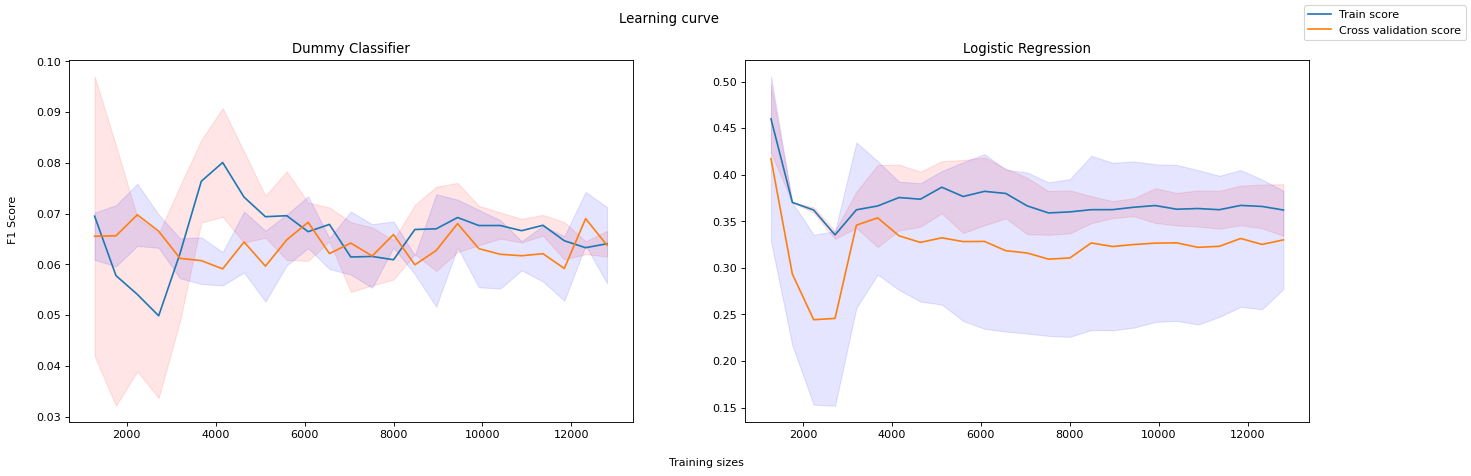

In [32]:
analyseModel([DummyClassifier(strategy="uniform"), LogisticRegression(), 'Dummy Classifier', 'Logistic Regression'])

<b><i>KNeighborsClassifier</i></b> performs a lot better than the baseline model and <b><i>LogisticRegression</i></b> but only returns mediocre <b><i>F1</i></b> train and test scores.

<b><i>GradientBoostingClassifier</i></b> performs significantly better than the baseline model, <b><i>LogisticRegression</i></b> and <b><i>KNeighborsClassifier</i></b> and also returns decent <b><i>F1</i></b> train and test scores.

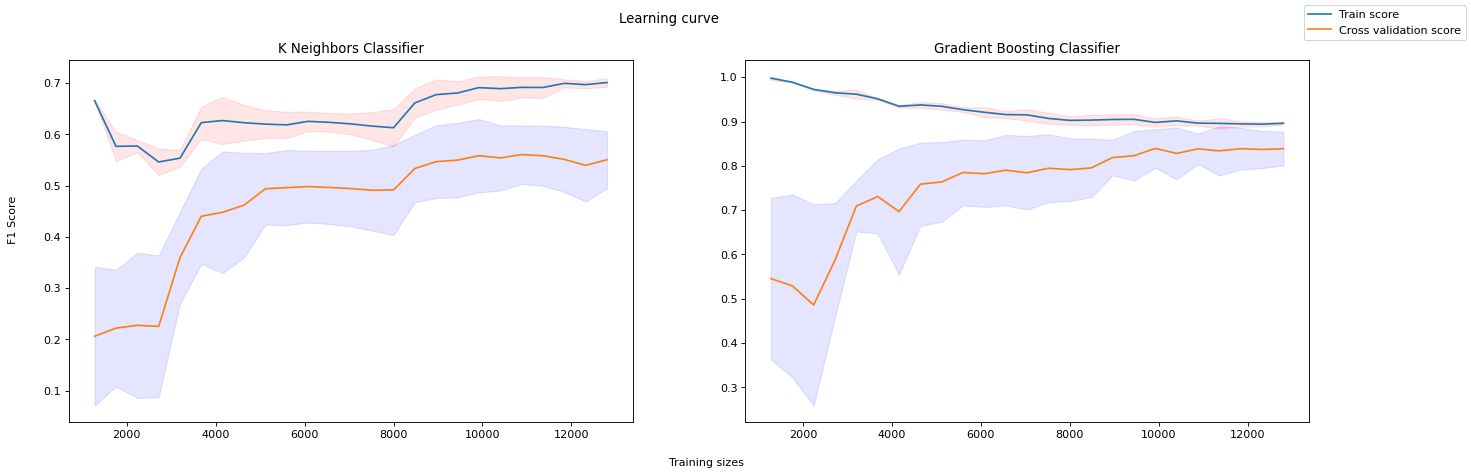

In [33]:
analyseModel([KNeighborsClassifier(), GradientBoostingClassifier(random_state=randoms), 'K Neighbors Classifier', 'Gradient Boosting Classifier'])

For <b><i>DecisionTreeClassifier</i></b> and <b><i>RandomForestClassifier</i></b>, they both perform very well as compared to the other models, significantly better than the baseline model, returning high <b><i>F1</i></b> scores. 

But it can be seen that <b><i>RandomForestClassifier</i></b> inches ahead in terms of <b><i>F1</i></b> test score.

Therefore, the final model selected would be <b><i>RandomForestClassifier<i></b>.

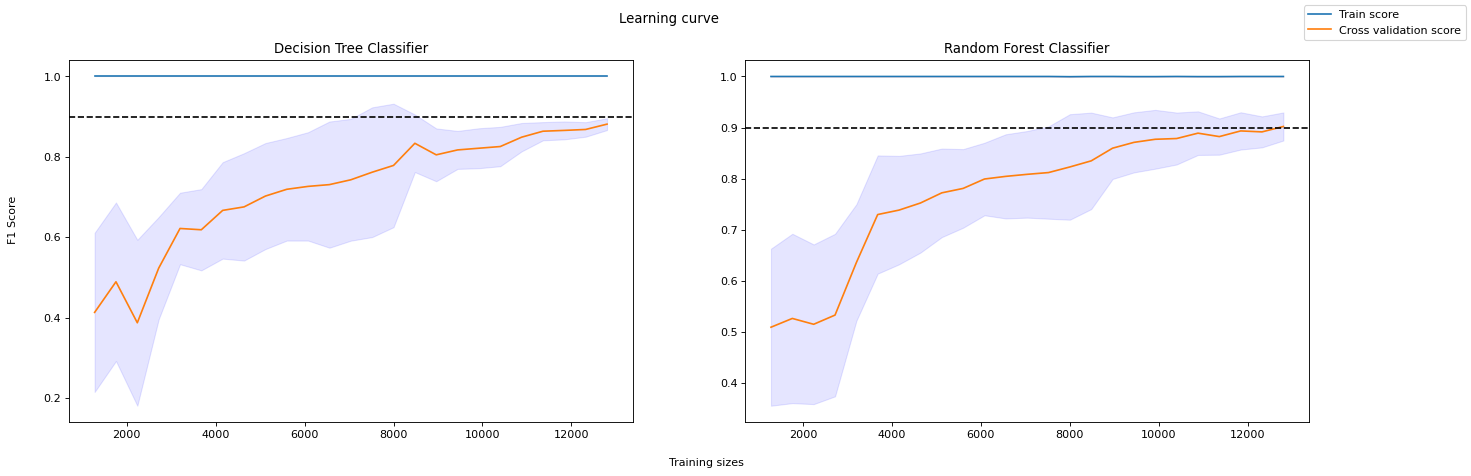

In [34]:
analyseModel([DecisionTreeClassifier(random_state=randoms), RandomForestClassifier(random_state=randoms), 
             'Decision Tree Classifier', 'Random Forest Classifier'])

Plot validation curves to see how performance of RandomForestClassifier changes as max_depth and n_estimators increase

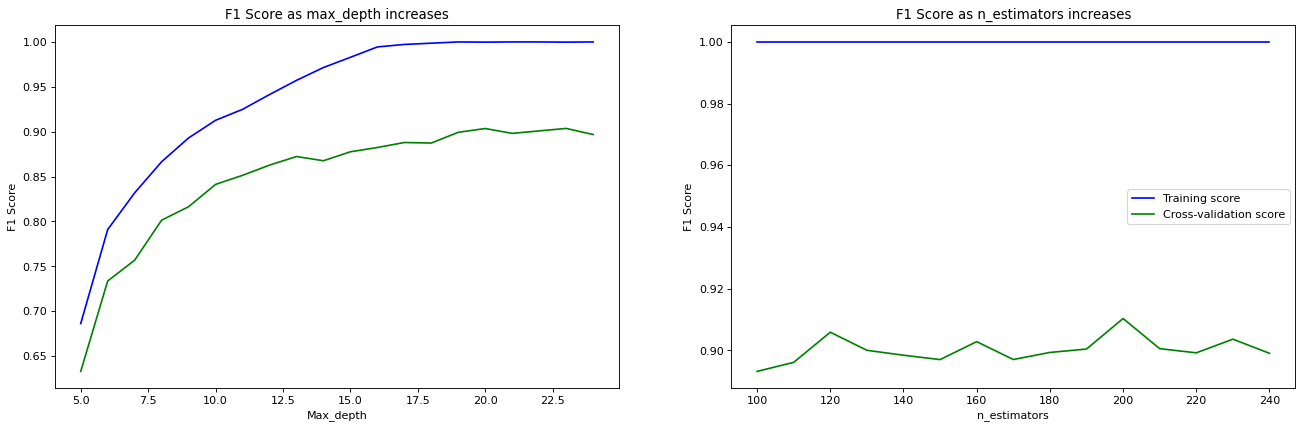

In [35]:
max_depth_range = np.arange(5,25,1)
n_estimators_range = np.arange(100,250,10)

fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=80)

train_scores, valid_scores = validation_curve(
    RandomForestClassifier(), X_train, y_train, param_name="max_depth", param_range=max_depth_range, scoring="f1", cv=5, n_jobs=-1)

ax[0].plot(max_depth_range, np.mean(train_scores, axis=1), label="Training score", color="b")
ax[0].plot(max_depth_range, np.mean(valid_scores, axis=1), label="Cross-validation score",color="g") 

ax[0].set_xlabel('Max_depth')
ax[0].set_ylabel('F1 Score')
ax[0].set_title('F1 Score as max_depth increases')

train_scores, valid_scores = validation_curve(
    RandomForestClassifier(), X_train, y_train, param_name="n_estimators", param_range=n_estimators_range, scoring="f1", cv=5, n_jobs=-1)

ax[1].plot(n_estimators_range, np.mean(train_scores, axis=1), label="Training score", color="b")
ax[1].plot(n_estimators_range, np.mean(valid_scores, axis=1), label="Cross-validation score",color="g") 

ax[1].set_xlabel('n_estimators')
ax[1].set_ylabel('F1 Score')
ax[1].set_title('F1 Score as n_estimators increases')

plt.legend(loc='best')
plt.show()

# Model Improvement

<b>Feature Selection</b>

Drop the two original temperature features that were used for feature creation. 

Only these two will be dropped and not the other two features, 'Rotation Speed (rpm)' and 'Torque (Nm)', firstly because if these two features were to be dropped as well, we would only be left with 4 features and this will mean that the model will be prone to underfitting when predicting for machine status. 

Secondly, the 'Rotation Speed (rpm)' and 'Torque (Nm)' features have a higher correlation to the target variable which indicates that it would affect the model performance more as compared to the temperature features. 

This reduces the 'noise' in the dataset which prevents the algorithm from interpreting the noises as patterns.

In [36]:
X_train.drop(['Ambient T (C)', 'Process T (C)'], axis=1, inplace=True)
X_test.drop(['Ambient T (C)', 'Process T (C)'], axis=1, inplace=True)

<b>Hyperparameter Tuning</b>

We will use <i>GridSearchCV()</i> to simplify our model and see if there will be a better performance for <i>RandomForestClassifier</i> by tuning the 'n_estimators', 'max_depth', 'criterion', 'bootstrap' and 'class_weight' parameters.

We set 'bootstrap' to `False` because our data is very imbalanced, there is a high chance that the bootstrap samples will contain few or none of the minority class and in our case - machine status of 1. This might cause our model to be bad at predicting the minority class and it should be something to avoid.

Next, 'class_weight' is set to `balanced`, this is to counter the problem of RandomForest being bias to the majority class, enforcing a heavier penalty on missclassifying the minority class. 

(From the sklearn documentation it states that when 'class-weight' is set to `balanced`, it uses the inverse weighting of the training dataset, which gives focus to the minority class)

In [37]:
params = {
    'max_depth' : np.arange(15, 25, 1),
    'n_estimators': np.arange(150,251,10),
    'bootstrap': [False],
    'criterion':['entropy','gini'],
    'class_weight': ['balanced']
}

gridModel = GridSearchCV(RandomForestClassifier(random_state=randoms), params, cv=5, scoring="f1", n_jobs=-1, verbose=3)

gridModel.fit(X_train, y_train)
y_pred = gridModel.predict(X_test)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


# Model Evaluation

For the model evaluation our primary metric that is to be focused on will be the <b><i>F1</i></b> score. We would then further evaluate our model by using the confusion matrix.

For model interpretability, we would plot the feature importance as well a permutation importance to see which features our model depend on the most.

In [38]:
print(classification_report(y_test, y_pred))
print(f"Best params: {gridModel.best_params_}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3864
           1       0.99      0.98      0.99       136

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000

Best params: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 21, 'n_estimators': 150}


In [39]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")

Accuracy: 0.999
Precision: 0.9925373134328358
Recall: 0.9779411764705882
F1: 0.9851851851851852


The final model returns an <b><i>F1</i></b> score of <b>0.985</b> on a held-out test set. Which is quite a good score. Lets plot the confusion matrix to further evaluate our model.

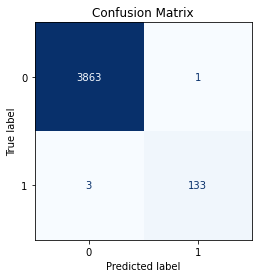

In [40]:
CMdisplay = ConfusionMatrixDisplay.from_estimator(
    gridModel,
    X_test,
    y_test,
    cmap="Blues"
)

CMdisplay.ax_.set_title('Confusion Matrix')
CMdisplay.im_.colorbar.remove()

From the confusion matrix, we can see that our model was able to predict the negative classes very well with only 1 false positive. However, it was not able to predict as well for the positive class with 3 false negatives.

<b>Model Interpretability<b>

In [41]:
feature_importances = pd.DataFrame(gridModel.best_estimator_.feature_importances_, index=X_train.columns, 
                                   columns=['Importance']).sort_values('Importance', ascending=False)

feature_importances

,Importance
Torque (Nm),0.229611
Tool Wear (min),0.228603
Power (W),0.207344
Rotation Speed (rpm),0.180928
Temperature Difference (C),0.140619
Quality,0.012895
